# Segmentez des clients d'un site e-commerce

# *Mission*
    Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.
    Vous créez donc un notebook et démarrez votre travail d’analyse exploratoire.
    
    Vous réalisez donc trois autres documents afin de préparer une réponse à Olist : 

        * un notebook avec des essais des différentes approches de modélisation ;
        * un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation, afin que celui-ci reste pertinent ; 
        * une présentation pour un collègue afin d’obtenir ses retours sur votre approche.


# *Livrables*
    * Un notebook de l'analyse exploratoire (non cleané, pour comprendre votre démarche).
    * Un notebook (ou code commenté au choix) d’essais des différentes approches de modélisation (non cleané, pour comprendre votre démarche).
    * Un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation.
    * Un support de présentation pour présenter votre travail à un collègue.

In [17]:
# Importation librairies
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

# Encodage
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Normalization
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer

# Imputation
from sklearn.impute import SimpleImputer

# Featurs selection

# Création de pipelines
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector

# Séparateur de jeu de données
from sklearn.model_selection import train_test_split 

# Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor




In [18]:
#********************************** Calcule des valeurs nulles + pourcentage: ******************************
def calc_inf (df,line):
    
    # ****************** Définition des variabes************************************************************
    nb_line_nan = nb_line_mix = nb_line_ssna= nb_col_nan = nb_col_mix = nb_col_ssna = 0   
         
    #***************************************************** Les statistiques NaN par colonne*****************
    
    n_list = df.isnull().sum().tolist()
    for i in range(len(n_list)):
        if n_list[i] == 0:                     # Nombre de colonnes sans NaN
            nb_col_ssna += 1  
        elif n_list[i] == len(df):             # Nombre de colonnes nulles
            nb_col_nan += 1
        elif 0 < n_list[i] < len(df):          # Nombre de colonnes mixtes
            nb_col_mix += 1
    print("* Nombre de colonnes sans NaN -------:",nb_col_ssna)
    print("* Nombre de colonnes NaN ------------:", nb_col_nan)
    print("* Nombre de colonnes mixtes----------:",nb_col_mix)
   # *************************************** Les statistiques NaN par ligne ********************************

    if line == True:
        for j in range(len(df.index)) :
            if df.iloc[j].isnull().sum() == len(df.columns):         # Nombre de lignes nulles
                nb_line_nan += 1
            elif 0 < df.iloc[j].isnull().sum() < len(df.columns):    # Nombre de lignes mixtes
                nb_line_mix += 1
            elif df.iloc[j].isnull().sum() == 0:                     # Nombre de lignes sans NaN
                nb_line_ssna += 1
        print("* Nombre de ligne entièrement nulles :",nb_line_nan)  
        print("* Nombre de ligne mixtes ----------- :", nb_line_mix) 
        print("* Nombre de ligne sans NaN ----------:", nb_line_ssna)
    #*******************************************************************************************************
    nb_line = df.index.size
    nb_colonne = df.columns.size
    tot = (nb_colonne*nb_line)
    nan = df.isnull().sum().sum()
    nan_prcnt = (100 * nan) / tot
    not_nan = df.notna().sum().sum()
    not_nan_prcnt = float((100 * not_nan) / tot)
    #*******************************************************************************************************
    
    print("* Nombre de lignes -----------------------: {:.0f}".format(nb_line))
    print("* Nombre de colonnes ---------------------: {:.0f}".format(nb_colonne))
    print("* Nombre de cases ------------------------: {:.0f}".format(tot))
    print("* Nombre de valeurs nulles ---------------: {:.0f}".format(nan))
    print("* Nombre de valeurs non nulles -----------: {:.0f}".format(not_nan))
    print("* le pourcentage des valeurs nulles ------:",str("%.1f" % nan_prcnt) + ' %')
    print("* le pourcentage des valeurs non nulles --:",str("%.1f" % not_nan_prcnt) + ' %')
    #a = pd.concat([not_nan_prcnt,nan_prcnt])
    # *******************************************************************************************************
    
    t= [not_nan_prcnt, nan_prcnt]
    plt.pie(t, labels = ['Valeurs non nulles', 
                         'Valeurs nulles (NaN)'],colors =['c', 'r'],
            startangle = 90, shadow = True, explode =(0,0.1),
            autopct = "%1.1f%%", normalize = True)
    plt.title("Le taux de remplissage en %")
    plt.show()

In [19]:
def pie_pc(df):
    nb_line = df.index.size
    nb_colonne = df.columns.size
    tot = (nb_colonne*nb_line)
    nan_prcnt = float((100 * df.isnull().sum().sum()) / tot)
    not_nan_prcnt = float((100 * df.notna().sum().sum()) / tot)
    t= [not_nan_prcnt,nan_prcnt]
    plt.pie(t, labels = ['Valeurs non nulles', 'Valeurs nulles (NaN)'],colors =['c', 'r'],
    startangle = 90, shadow = True, explode =(0,0.1), autopct = "%1.1f%%", normalize = True)
    plt.title("Le taux de remplissage en %")
    plt.show()

In [89]:
#************************************ Valeurs manquantes et pourcentage en tableau % **************************************

def mssng_val(df):
    mssng_t = pd.DataFrame(columns=['Variable_name', 'Missing_values', 'Missing_rate'])
    mssng_t['Variable_name'] = df.columns
    
    missing = list()
    percentage_missing = list()
    
    for col in df.columns:
        nb_missing = df[col].isna().sum()                  # le nombre des valeurs NaN par colonne
        pc_missing = df[col].isna().sum()/df[col].size     # le pourcentage des valeurs NaN par colonne
        
        missing.append(nb_missing)
        percentage_missing.append(pc_missing)
        
    mssng_t['Missing_values'] = list(missing)
    mssng_t['Missing_rate'] = list(percentage_missing)
    mssng_t = mssng_t.sort_values(by= ['Missing_values'], ascending = False)
    return mssng_t

# 1. Récupération de données
***

In [20]:

customers      = pd.read_csv('D:\Projet Classrooms\Projet_5\olist_customers_dataset.csv', sep=',')
geolocation    = pd.read_csv('D:\Projet Classrooms\Projet_5\olist_geolocation_dataset.csv', sep=',')
order_items    = pd.read_csv('D:\Projet Classrooms\Projet_5\olist_order_items_dataset.csv', sep=',')
order_payments = pd.read_csv('D:\Projet Classrooms\Projet_5\olist_order_payments_dataset.csv', sep=',')
order_reviews  = pd.read_csv('D:\Projet Classrooms\Projet_5\olist_order_reviews_dataset.csv', sep=',')
orders         = pd.read_csv('D:\Projet Classrooms\Projet_5\olist_orders_dataset.csv', sep=',')
products       = pd.read_csv('D:\Projet Classrooms\Projet_5\olist_products_dataset.csv', sep=',')
sellers        = pd.read_csv('D:\Projet Classrooms\Projet_5\olist_sellers_dataset.csv', sep=',')
translation    = pd.read_csv('D:\Projet Classrooms\Projet_5\product_category_name_translation.csv', sep=',')


# 2. Aperçu de chaque Data-Set
***

In [21]:
customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [22]:
geolocation.head(2)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


In [23]:
# Information sur les commandes, cout de livraison, date de livraison, id_vendeur, id_produit, ....>>> côté vendeur
order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [24]:
# information sur les paiement des commandes
order_payments.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


In [25]:
# informations sur les reveiws de chaque commande...
order_reviews.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [26]:
# Status de la commandes après l'achat
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [27]:
# Information sur les produits
products.head(2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


In [28]:
# Information sur les vendeurs
sellers.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


In [29]:
# Translation des catégories de produits en anglais 
translation.head(2)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


# 3. Informations générales de données: dimension, NaN ....
***

In [30]:
dict = {'customers'     : customers,
        'geolocation'   : geolocation,
        'order_items'   : order_items,
        'order_payments': order_payments,
        'order_reviews' : order_reviews,
        'orders'        : orders,
        'products'      : products,
        'sellers'       : sellers,
        'translation'   : translation
       }


------- customers -------

* Nombre de colonnes sans NaN -------: 5
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 0
* Nombre de lignes -----------------------: 99441
* Nombre de colonnes ---------------------: 5
* Nombre de cases ------------------------: 497205
* Nombre de valeurs nulles ---------------: 0
* Nombre de valeurs non nulles -----------: 497205
* le pourcentage des valeurs nulles ------: 0.0 %
* le pourcentage des valeurs non nulles --: 100.0 %


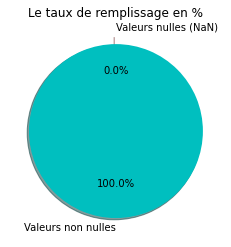

---------------------------------------------------------------------------------------------------- 

------- geolocation -------

* Nombre de colonnes sans NaN -------: 5
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 0
* Nombre de lignes -----------------------: 1000163
* Nombre de colonnes ---------------------: 5
* Nombre de cases ------------------------: 5000815
* Nombre de valeurs nulles ---------------: 0
* Nombre de valeurs non nulles -----------: 5000815
* le pourcentage des valeurs nulles ------: 0.0 %
* le pourcentage des valeurs non nulles --: 100.0 %


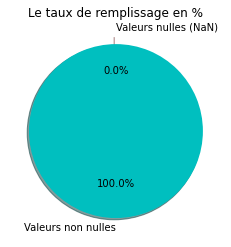

---------------------------------------------------------------------------------------------------- 

------- order_items -------

* Nombre de colonnes sans NaN -------: 7
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 0
* Nombre de lignes -----------------------: 112650
* Nombre de colonnes ---------------------: 7
* Nombre de cases ------------------------: 788550
* Nombre de valeurs nulles ---------------: 0
* Nombre de valeurs non nulles -----------: 788550
* le pourcentage des valeurs nulles ------: 0.0 %
* le pourcentage des valeurs non nulles --: 100.0 %


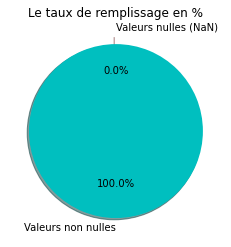

---------------------------------------------------------------------------------------------------- 

------- order_payments -------

* Nombre de colonnes sans NaN -------: 5
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 0
* Nombre de lignes -----------------------: 103886
* Nombre de colonnes ---------------------: 5
* Nombre de cases ------------------------: 519430
* Nombre de valeurs nulles ---------------: 0
* Nombre de valeurs non nulles -----------: 519430
* le pourcentage des valeurs nulles ------: 0.0 %
* le pourcentage des valeurs non nulles --: 100.0 %


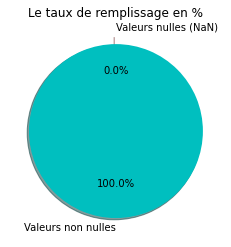

---------------------------------------------------------------------------------------------------- 

------- order_reviews -------

* Nombre de colonnes sans NaN -------: 5
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 2
* Nombre de lignes -----------------------: 99224
* Nombre de colonnes ---------------------: 7
* Nombre de cases ------------------------: 694568
* Nombre de valeurs nulles ---------------: 145903
* Nombre de valeurs non nulles -----------: 548665
* le pourcentage des valeurs nulles ------: 21.0 %
* le pourcentage des valeurs non nulles --: 79.0 %


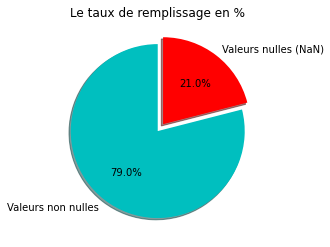

---------------------------------------------------------------------------------------------------- 

------- orders -------

* Nombre de colonnes sans NaN -------: 5
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 3
* Nombre de lignes -----------------------: 99441
* Nombre de colonnes ---------------------: 8
* Nombre de cases ------------------------: 795528
* Nombre de valeurs nulles ---------------: 4908
* Nombre de valeurs non nulles -----------: 790620
* le pourcentage des valeurs nulles ------: 0.6 %
* le pourcentage des valeurs non nulles --: 99.4 %


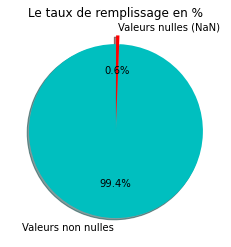

---------------------------------------------------------------------------------------------------- 

------- products -------

* Nombre de colonnes sans NaN -------: 1
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 8
* Nombre de lignes -----------------------: 32951
* Nombre de colonnes ---------------------: 9
* Nombre de cases ------------------------: 296559
* Nombre de valeurs nulles ---------------: 2448
* Nombre de valeurs non nulles -----------: 294111
* le pourcentage des valeurs nulles ------: 0.8 %
* le pourcentage des valeurs non nulles --: 99.2 %


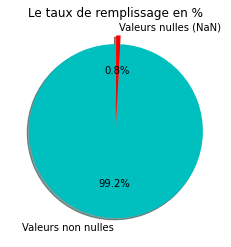

---------------------------------------------------------------------------------------------------- 

------- sellers -------

* Nombre de colonnes sans NaN -------: 4
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 0
* Nombre de lignes -----------------------: 3095
* Nombre de colonnes ---------------------: 4
* Nombre de cases ------------------------: 12380
* Nombre de valeurs nulles ---------------: 0
* Nombre de valeurs non nulles -----------: 12380
* le pourcentage des valeurs nulles ------: 0.0 %
* le pourcentage des valeurs non nulles --: 100.0 %


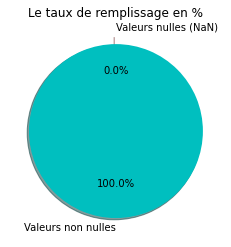

---------------------------------------------------------------------------------------------------- 

------- translation -------

* Nombre de colonnes sans NaN -------: 2
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 0
* Nombre de lignes -----------------------: 71
* Nombre de colonnes ---------------------: 2
* Nombre de cases ------------------------: 142
* Nombre de valeurs nulles ---------------: 0
* Nombre de valeurs non nulles -----------: 142
* le pourcentage des valeurs nulles ------: 0.0 %
* le pourcentage des valeurs non nulles --: 100.0 %


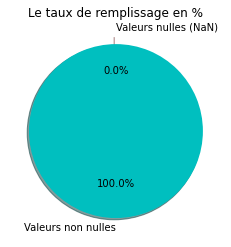

---------------------------------------------------------------------------------------------------- 



In [31]:
for tab_name, tab in dict.items():
    print('-------',tab_name,'-------\n')
    calc_inf(tab, False)
    print('-'*100,'\n')

****
    * On a des valeurs NaN uniquement dans order_reviews, orders et products

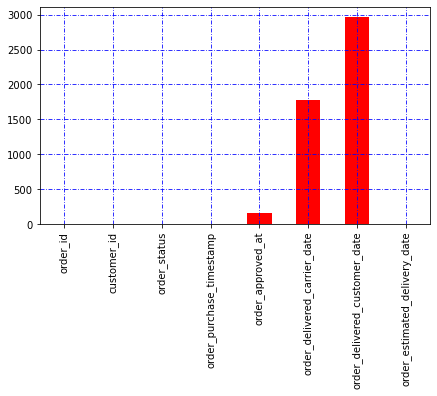

In [32]:
orders.isna().sum().plot(kind = 'bar',color = 'r',figsize=(7,4))
plt.xticks(rotation=90)
plt.grid(True, color='blue', dashes=(5,2,1,2))

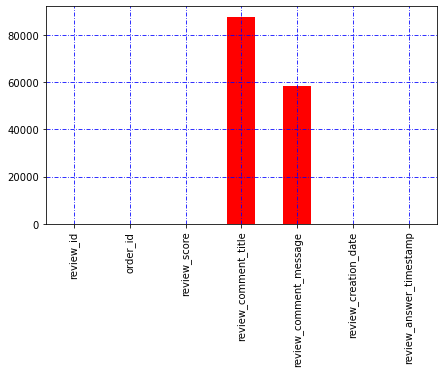

In [33]:
order_reviews.isna().sum().plot(kind = 'bar',color = 'r', figsize=(7,4))
plt.xticks(rotation=90)
plt.grid(True, color='blue', dashes=(5,2,1,2))

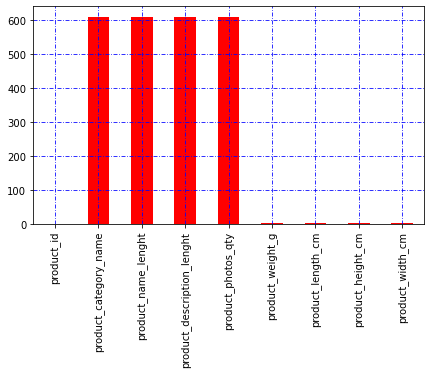

In [34]:
products.isna().sum().plot(kind = 'bar',color = 'r',figsize=(7,4))
plt.xticks(rotation=90)
plt.grid(True, color='blue', dashes=(5,2,1,2))

# 4. Nettoyage et merge des tables

****
    * product_id >>>
    * order_payments (order_id)  >>>> orders
    *  order_items >>> order_id >>> order_item_id >>> product_id >>> seller_id

In [35]:
order_items.shape

(112650, 7)

In [36]:
products.shape

(32951, 9)

In [37]:
lis_1 = []
for tab_name, tab in dict.items(): 
    lis_1.append([tab_name, tab.shape])
  
z = pd.DataFrame(lis_1, columns=['Table', 'Size'])
z

,Table,Size
0,customers,"(99441, 5)"
1,geolocation,"(1000163, 5)"
2,order_items,"(112650, 7)"
3,order_payments,"(103886, 5)"
4,order_reviews,"(99224, 7)"
5,orders,"(99441, 8)"
6,products,"(32951, 9)"
7,sellers,"(3095, 4)"
8,translation,"(71, 2)"


In [38]:
df=[customers, geolocation, order_items, order_payments, order_reviews, orders, products, sellers,translation]

In [39]:
customers['customer_unique_id'].duplicated().sum()

3345

In [40]:
customers['customer_id'].isin(customers['customer_unique_id']).unique()


array([False])

In [41]:
orders['customer_id'].isin(customers['customer_id']).unique()


array([ True])

In [42]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [43]:
 orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

### Le merge de customers avec orders via customer_id

In [45]:
custm_ordres = customers.merge(right = orders, on='customer_id', how='left')

In [49]:
custm_ordres

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25 00:00:00
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20 00:00:00
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02 00:00:00
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05 00:00:00


In [50]:
custm_ordres.nunique()

customer_id                      99441
customer_unique_id               96096
customer_zip_code_prefix         14994
customer_city                     4119
customer_state                      27
order_id                         99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [51]:
custm_ordres.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [52]:
custm_ordres.shape

(99441, 12)


    * après le merge de customers et orders la taille du nouveau data-set est (99441, 12), avant le merge
    avec ordre_payement, on fait la somme des valeurs payées regroupées par ***ordres_id*** pour que la taille de ordre_payment (103886 × 5) égale à la mème taille que cust_ordre pour pouvoir les merger
****

### Calcul de payement_value en fonction de de order_id

In [53]:
order_payments.head(4)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78


In [54]:
payment_sum = order_payments.groupby('order_id').agg({'payment_value': 'sum'}).reset_index()

In [55]:
payment_sum.head(4)

,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78


### Le merge de order_payments avec custm_orders

    * Maintenant on pourrait faire le merger avec custm_orders 


In [56]:
cust_ord_pmt = custm_ordres.merge(right = payment_sum, on='order_id', how='left')

In [57]:
cust_ord_pmt.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73


### Calcul de delivery_time en fonction de "order_purchase_timestamp" et "order_delivered_customer_date"

     * dans un premier temps on va garder que order_status delivered, corriger le Dtypes de feauters puis le calcul de "delivery_time"


In [58]:
cust_ord_pmt['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

### Gerder que les commande "delivered"

In [59]:
delevered = cust_ord_pmt['order_status'] == 'delivered'

In [60]:
cust_ord_pmt = cust_ord_pmt[delevered]

In [61]:
cust_ord_pmt.shape

(96478, 13)

In [62]:
cust_ord_pmt.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73


In [63]:
list_date=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
           'order_delivered_customer_date','order_estimated_delivery_date']
for x in list_date:
        cust_ord_pmt[x] =cust_ord_pmt[x].astype('datetime64')

In [64]:
cust_ord_pmt.shape

(96478, 13)

### Calcul de 'delivery_time'

In [65]:
cust_ord_pmt['delivery_time'] =  cust_ord_pmt.order_delivered_customer_date - cust_ord_pmt.order_purchase_timestamp

In [66]:
cust_ord_pmt.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value,delivery_time
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,146.87,8 days 19:30:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,335.48,16 days 15:52:55
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,157.73,26 days 01:51:06


### Calcule et merge de review_score avec cust_ord_pmt

In [67]:
order_reviews.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


In [68]:
order_reviews['order_id'].value_counts().max()

3

In [69]:
order_reviews['review_score'].value_counts()

5    57328
4    19142
1    11424
3     8179
2     3151
Name: review_score, dtype: int64

In [70]:
reviews_score = order_reviews.groupby('order_id').agg({'review_score': 'mean'}).reset_index()

In [74]:
reviews_score.head(3)

,order_id,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,5.0
1,00018f77f2f0320c557190d7a144bdd3,4.0
2,000229ec398224ef6ca0657da4fc703e,5.0


In [75]:
cust_ord_pmt_scr = cust_ord_pmt.merge(right = reviews_score, on='order_id', how='left')

In [76]:
cust_ord_pmt_scr.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value,delivery_time,review_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,146.87,8 days 19:30:00,4.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,335.48,16 days 15:52:55,5.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,157.73,26 days 01:51:06,5.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,173.30,14 days 23:57:47,5.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,252.25,11 days 11:04:18,5.0



### Mnt on va les regrouper par "customer_unique_id"  
***

In [77]:
data = cust_ord_pmt_scr.groupby('customer_unique_id').agg({'order_id'                : 'count', 
                                                           'order_purchase_timestamp': ['max','min'],
                                                           'payment_value'           : ['sum','mean'],
                                                           'delivery_time'           : 'mean',
                                                           'review_score'            : 'mean',})

In [78]:
data.head()

order_id order_purchase_timestamp  \
                                    count                      max   
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2        1      2018-05-10 10:56:27   
0000b849f77a49e4a4ce2b2a4ca5be3f        1      2018-05-07 11:11:27   
0000f46a3911fa3c0805444483337064        1      2017-03-10 21:05:03   
0000f6ccb0745a6a4b88665a16c9f078        1      2017-10-12 20:29:41   
0004aac84e0df4da2b147fca70cf8255        1      2017-11-14 19:45:42   

                                                     payment_value          \
                                                 min           sum    mean   
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27        141.90  141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27         27.19   27.19   
0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03         86.22   86.22   
0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41         43.62   43.62   
0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42        196.89  196.89   

                                    delivery_time review_score  
                                             mean         mean  
customer_unique_id                                              
0000366f3b9a7992bf8c76cfdf3221e2  6 days 09:52:10          5.0  
0000b849f77a49e4a4ce2b2a4ca5be3f  3 days 06:51:15          4.0  
0000f46a3911fa3c0805444483337064 25 days 17:33:44          3.0  
0000f6ccb0745a6a4b88665a16c9f078 20 days 00:53:24          4.0  
0004aac84e0df4da2b147fca70cf8255 13 days 03:23:14          5.0

In [79]:
data.columns = [j+'_'+i for i, j in data.columns]

In [80]:
data = data.reset_index()

In [81]:
data['mean_delivery_time'] = data['mean_delivery_time'].apply(lambda x: x.days)

In [82]:
data.head(3)

,customer_unique_id,count_order_id,max_order_purchase_timestamp,min_order_purchase_timestamp,sum_payment_value,mean_payment_value,mean_delivery_time,mean_review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,141.90,6.0,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,27.19,3.0,4.0
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,86.22,86.22,25.0,3.0


In [83]:
data.nunique()

customer_unique_id              93358
count_order_id                      9
max_order_purchase_timestamp    93112
min_order_purchase_timestamp    93115
sum_payment_value               28262
mean_payment_value              28426
mean_delivery_time                145
mean_review_score                  34
dtype: int64

In [84]:
data['mean_review_score'] = data['mean_review_score'].round()

In [85]:
data.mean_review_score.value_counts()

5.0    54489
4.0    18707
1.0     8918
3.0     7701
2.0     2940
Name: mean_review_score, dtype: int64

***
### Calcul du délai depuis le dernier achat:

    * Maintenant on va calculer le délai depuis le dernier achat ***max_order_purchase_timestamp***
***

In [86]:
import datetime as dt

date = dt.datetime(2022, 4, 24, 11, 56, 20)
print(date)

2022-04-24 11:56:20


In [87]:
data['delta_time'] = (date - data['max_order_purchase_timestamp']).apply(lambda x: x.days)
data.head()

,customer_unique_id,count_order_id,max_order_purchase_timestamp,min_order_purchase_timestamp,sum_payment_value,mean_payment_value,mean_delivery_time,mean_review_score,delta_time
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,141.90,6.0,5.0,1445
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,27.19,3.0,4.0,1448
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,86.22,86.22,25.0,3.0,1870
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-10-12 20:29:41,43.62,43.62,20.0,4.0,1654
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-14 19:45:42,196.89,196.89,13.0,5.0,1621


In [88]:
data.isnull().sum()

customer_unique_id                0
count_order_id                    0
max_order_purchase_timestamp      0
min_order_purchase_timestamp      0
sum_payment_value                 0
mean_payment_value                1
mean_delivery_time                8
mean_review_score               603
delta_time                        0
dtype: int64

In [90]:
nan_data_uni= mssng_val(data)
nan_data_uni

,Variable_name,Missing_values,Missing_rate
7,mean_review_score,603,0.006459
6,mean_delivery_time,8,0.000086
5,mean_payment_value,1,0.000011
0,customer_unique_id,0,0.000000
1,count_order_id,0,0.000000
2,max_order_purchase_timestamp,0,0.000000
3,min_order_purchase_timestamp,0,0.000000
4,sum_payment_value,0,0.000000
8,delta_time,0,0.000000


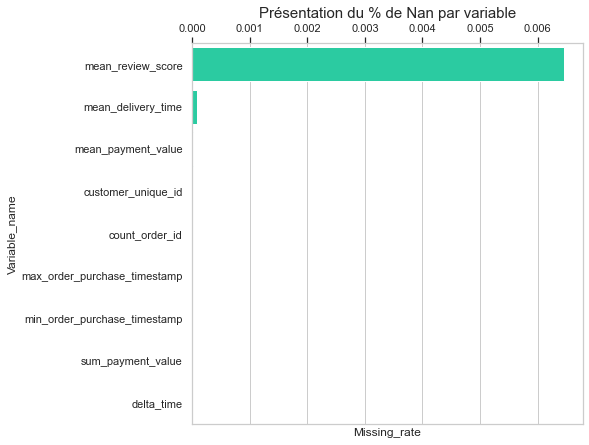

In [94]:
sns.set(style="whitegrid")
plt.figure(figsize=(7,7))
ax = sns.barplot(x = nan_data_uni['Missing_rate'], y = nan_data_uni['Variable_name'], orient = 'h',color = '#11E5AD' )
ax.xaxis.set_ticks_position('top')
plt.title('Présentation du % de Nan par variable', size=15)
plt.show()

C:\Users\Win\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


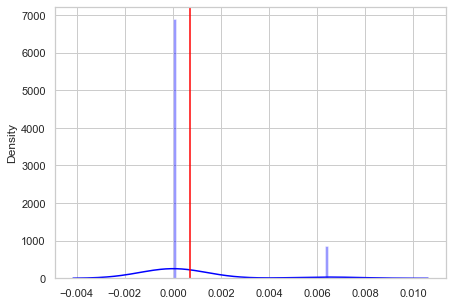

In [98]:
plt.figure(figsize=(7, 5))
dis_nan = nan_data_uni['Missing_rate'].values
sns.distplot(dis_nan, color= 'blue', kde=True)
mean = nan_data_uni['Missing_rate'].mean()
plt.axvline(mean, 0, 1, color='red')
plt.show()

In [99]:
data = data.dropna()

* Nombre de colonnes sans NaN -------: 9
* Nombre de colonnes NaN ------------: 0
* Nombre de colonnes mixtes----------: 0
* Nombre de ligne entièrement nulles : 0
* Nombre de ligne mixtes ----------- : 0
* Nombre de ligne sans NaN ----------: 92746
* Nombre de lignes -----------------------: 92746
* Nombre de colonnes ---------------------: 9
* Nombre de cases ------------------------: 834714
* Nombre de valeurs nulles ---------------: 0
* Nombre de valeurs non nulles -----------: 834714
* le pourcentage des valeurs nulles ------: 0.0 %
* le pourcentage des valeurs non nulles --: 100.0 %


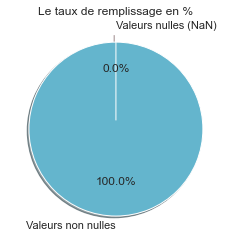

In [100]:
calc_inf(data, True)

In [101]:
data

,customer_unique_id,count_order_id,max_order_purchase_timestamp,min_order_purchase_timestamp,sum_payment_value,mean_payment_value,mean_delivery_time,mean_review_score,delta_time
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,141.90,6.0,5.0,1445
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,27.19,3.0,4.0,1448
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,86.22,86.22,25.0,3.0,1870
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-10-12 20:29:41,43.62,43.62,20.0,4.0,1654
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-14 19:45:42,196.89,196.89,13.0,5.0,1621
...,...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08 21:00:36,2017-06-08 21:00:36,2067.42,2067.42,27.0,5.0,1780
93354,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,2017-12-10 20:07:56,84.58,84.58,30.0,4.0,1595
93355,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,2017-02-07 15:49:16,112.46,112.46,14.0,5.0,1901
93356,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,2018-05-02 15:17:41,133.69,133.69,11.0,5.0,1452


In [102]:
data['mean_delivery_time'].min()

0.0

In [103]:
data.isnull().mean()

customer_unique_id              0.0
count_order_id                  0.0
max_order_purchase_timestamp    0.0
min_order_purchase_timestamp    0.0
sum_payment_value               0.0
mean_payment_value              0.0
mean_delivery_time              0.0
mean_review_score               0.0
delta_time                      0.0
dtype: float64

In [104]:
data["mean_delivery_time"].min()

0.0

### Suppréssion des délivery time égalent à 0
 * Suppréssion des valeurs abberantes de mean Delivery
   ***

In [109]:
not_zero = data['mean_delivery_time'] != 0
data = data[not_zero]

# 5. Export du data-Set final pour la modélisation

In [110]:
data.head()

,customer_unique_id,count_order_id,max_order_purchase_timestamp,min_order_purchase_timestamp,sum_payment_value,mean_payment_value,mean_delivery_time,mean_review_score,delta_time
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,141.90,6.0,5.0,1445
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,27.19,3.0,4.0,1448
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,86.22,86.22,25.0,3.0,1870
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-10-12 20:29:41,43.62,43.62,20.0,4.0,1654
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-14 19:45:42,196.89,196.89,13.0,5.0,1621


In [192]:
data.columns

Index(['customer_unique_id', 'count_order_id', 'max_order_purchase_timestamp',
       'min_order_purchase_timestamp', 'sum_payment_value',
       'mean_payment_value', 'mean_delivery_time', 'mean_review_score',
       'delta_time'],
      dtype='object')

In [111]:
rename_dict = {'customer_unique_id'          : 'unique_id',
               'count_order_id'              : 'Frequency',
               'max_order_purchase_timestamp': 'last_order_date',
               'min_order_purchase_timestamp': 'min_order_date', 
               'sum_payment_value'           : 'Monetary_sum',
               'mean_payment_value'          : 'Monetary_mean',
               'mean_delivery_time'          : 'Delivery_time', 
               'mean_review_score'           : 'Score_mean',
               'delta_time'                  : 'Recency'}

In [112]:
data.rename(columns = rename_dict, inplace=True)

In [113]:
data.head(5)

,unique_id,Frequency,last_order_date,min_order_date,Monetary_sum,Monetary_mean,Delivery_time,Score_mean,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,141.90,6.0,5.0,1445
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,27.19,3.0,4.0,1448
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,86.22,86.22,25.0,3.0,1870
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-10-12 20:29:41,43.62,43.62,20.0,4.0,1654
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-14 19:45:42,196.89,196.89,13.0,5.0,1621


In [114]:
data.drop(columns = ['unique_id','min_order_date', 'Monetary_mean'], inplace= True )

In [115]:
data = data[['Recency','Frequency','Monetary_sum','Delivery_time','Score_mean','last_order_date']]
data

,Recency,Frequency,Monetary_sum,Delivery_time,Score_mean,last_order_date
0,1445,1,141.90,6.0,5.0,2018-05-10 10:56:27
1,1448,1,27.19,3.0,4.0,2018-05-07 11:11:27
2,1870,1,86.22,25.0,3.0,2017-03-10 21:05:03
3,1654,1,43.62,20.0,4.0,2017-10-12 20:29:41
4,1621,1,196.89,13.0,5.0,2017-11-14 19:45:42
...,...,...,...,...,...,...
93353,1780,1,2067.42,27.0,5.0,2017-06-08 21:00:36
93354,1595,1,84.58,30.0,4.0,2017-12-10 20:07:56
93355,1901,1,112.46,14.0,5.0,2017-02-07 15:49:16
93356,1452,1,133.69,11.0,5.0,2018-05-02 15:17:41


In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92733 entries, 0 to 93357
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Recency          92733 non-null  int64         
 1   Frequency        92733 non-null  int64         
 2   Monetary_sum     92733 non-null  float64       
 3   Delivery_time    92733 non-null  float64       
 4   Score_mean       92733 non-null  float64       
 5   last_order_date  92733 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 5.0 MB


In [198]:
data.to_csv('D:\Projet Classrooms\Projet_5\data_cleaned.csv', index = False)

# Analyse exploratoir:

### Analyse exploratoir sur Data-Set préparé
***

In [120]:
data['last_order_date'].dtypes

dtype('<M8[ns]')

In [121]:
display(data['last_order_date'].min(), data['last_order_date'].max())

Timestamp('2016-10-03 16:56:50')

Timestamp('2018-08-29 15:00:37')

In [122]:
data_explt = data.sort_values(by=['last_order_date'], ascending = True)

In [123]:
data_explt.head()

,Recency,Frequency,Monetary_sum,Delivery_time,Score_mean,last_order_date
17361,2028,1,39.09,24.0,4.0,2016-10-03 16:56:50
35810,2028,1,53.73,30.0,3.0,2016-10-03 21:13:36
51400,2028,1,133.46,27.0,1.0,2016-10-03 22:06:03
49410,2028,1,40.95,10.0,5.0,2016-10-03 22:31:31
42237,2028,1,154.57,30.0,5.0,2016-10-03 22:44:10


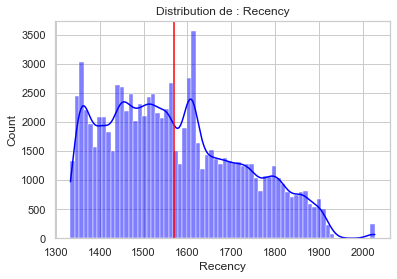

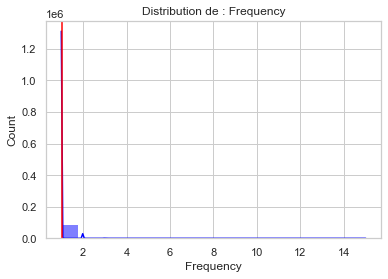

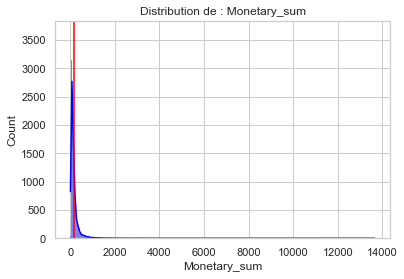

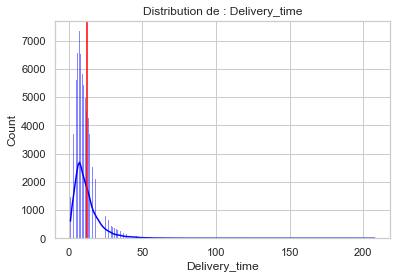

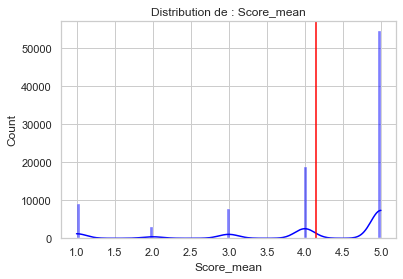

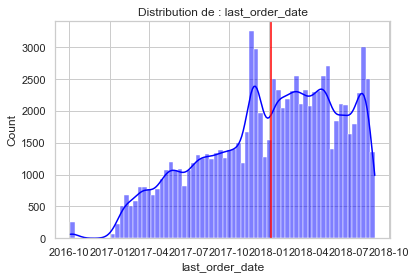

In [124]:
for col in data_explt.columns:
    #dis_nan_org = data_flt[col].values
    sns.histplot(data_explt[col], color= 'blue', kde=True)
    mean = data_explt[col].mean()
    plt.axvline(mean, 0, 1, color='red')
    plt.title('Distribution de : '+ col)
    plt.show()

Indicateurs de distribution pour Recency
--------------------------------------------------
count    92733.000000
mean      1570.578661
std        152.586071
min       1333.000000
25%       1447.000000
50%       1552.000000
75%       1679.000000
max       2028.000000
Name: Recency, dtype: float64
Indicateurs de distribution pour Frequency
--------------------------------------------------
count    92733.000000
mean         1.033548
std          0.209567
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: Frequency, dtype: float64
Indicateurs de distribution pour Monetary_sum
--------------------------------------------------
count    92733.000000
mean       164.953753
std        225.061569
min          9.590000
25%         63.010000
50%        107.780000
75%        182.320000
max      13664.080000
Name: Monetary_sum, dtype: float64
Indicateurs de distribution pour Delivery_time
---------------------------------------------

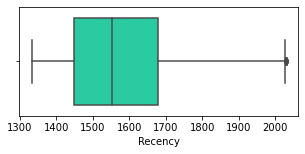

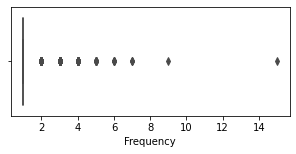

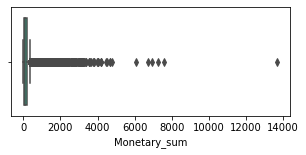

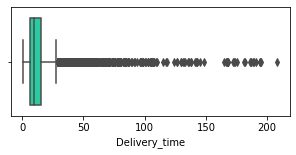

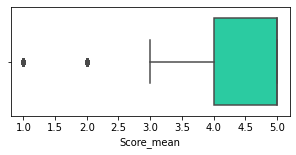

In [214]:
for col in ['Recency','Frequency','Monetary_sum','Delivery_time','Score_mean']:
    fig = plt.figure(figsize=(5, 2))
    
    sns.boxplot(x=data_explt[col], color='#11E5AD')
    print("Indicateurs de distribution pour",col)
    print('-'*50)
    print( data_explt[col].describe())

# Analyse multivariée

### Matrice de corrélation
    

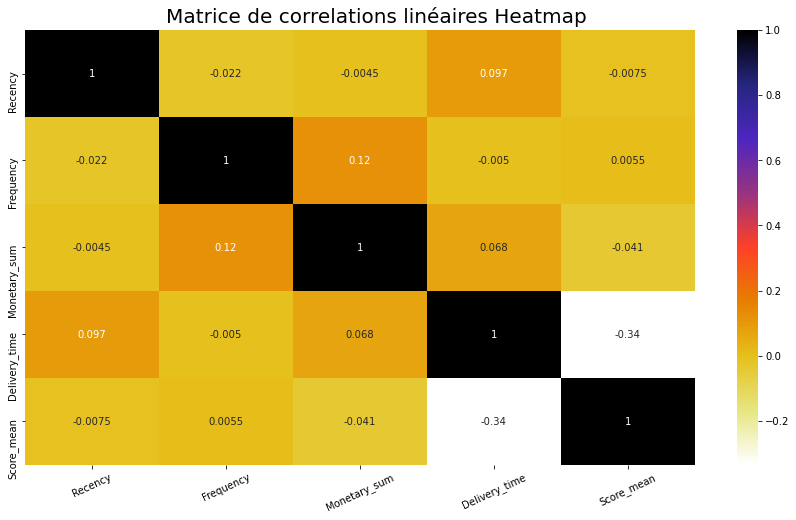

In [216]:

cor = data_explt.corr()
fig, ax = plt.subplots(figsize=(15,8)) 
sns.heatmap(cor, annot=True, cmap= plt.cm.CMRmap_r)
plt.suptitle('Matrice de correlations linéaires Heatmap',x=0.45,y=0.92, fontsize = 20)
plt.xticks(rotation=25)

plt.show()

* Comme illustré au-dessus on voit bien qu'il n y a pas de corrélation entres features, qui bien pour notre clustering 

In [ ]:
data_reduce = data.sample(10000, random_state=1).copy()
X = data_reduce.copy()